In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 15 12:53:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preprocess

In [ ]:
!pip install timeit
import timeit
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


ERROR: Could not find a version that satisfies the requirement timeit (from versions: none)
ERROR: No matching distribution found for timeit


# Date preparation

In [ ]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
#display(train_data, noisy_train_data)

11501568/11490434 [==============================] - 0s 0us/step


# Building the supporter autoencoder

## Part A

Model: "AE1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AE_input (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_model1 (Functional)  (None, 7, 7, 1)           9857      
_________________________________________________________________
decoder_model1 (Functional)  (None, 28, 28, 1)         609       
Total params: 10,466
Trainable params: 10,466
Non-trainable params: 0
_________________________________________________________________


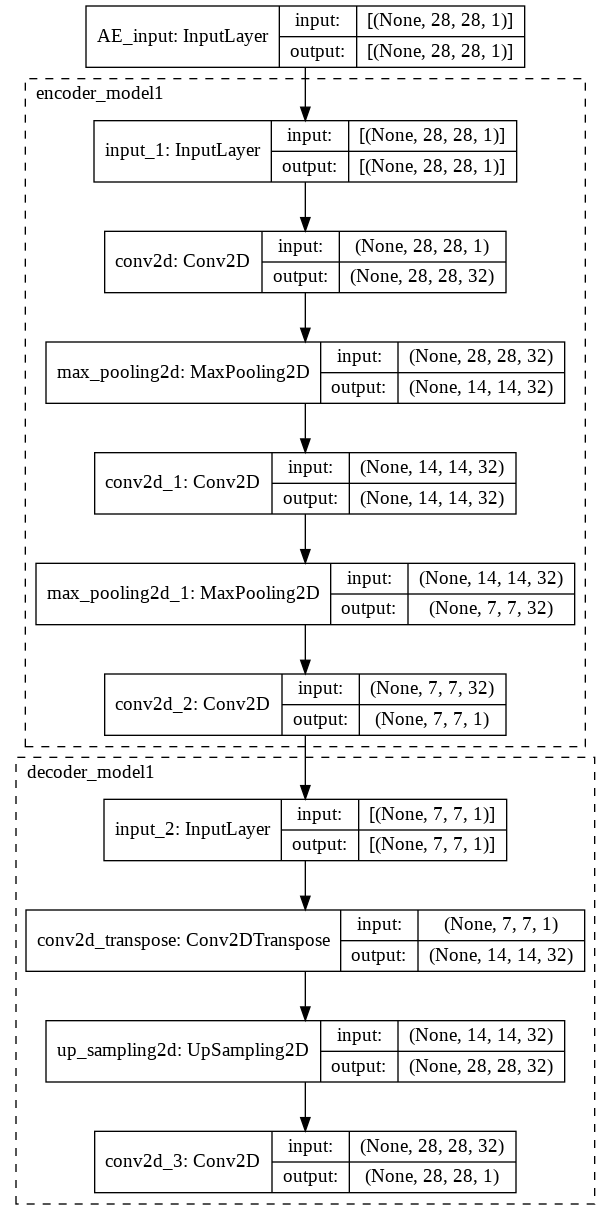

In [ ]:
#encoder
encoder_input1 = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input1)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)
encoder1 = Model(encoder_input1, x, name="encoder_model1")
# Decoder
decoder_input1 = layers.Input(shape=(7, 7, 1))
x = layers.Conv2DTranspose(32, (3, 3), strides = 2, activation="relu", padding="same")(decoder_input1)
x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoder1 = Model(decoder_input1, x, name="decoder_model1")

ae_input1 = layers.Input(shape=(28, 28, 1), name="AE_input")
ae_encoder_output1 = encoder1(ae_input1)
ae_decoder_output1 = decoder1(ae_encoder_output1)

autoencoder1 = Model(ae_input1, ae_decoder_output1, name="AE1")
autoencoder1.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder1.summary()

plot_model(autoencoder1, expand_nested=True, show_shapes=True)
#plot_model(decoder1)
#plot_model(autoencoder1)

In [ ]:
start = timeit.default_timer()

autoencoder1.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

end = timeit.default_timer()

print("autoencoder1 training time:", end-start)

Epoch 1/50
469/469 [==============================] - 34s 14ms/step - loss: 0.2173 - val_loss: 0.1281
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1154 - val_loss: 0.1084
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1072 - val_loss: 0.1048
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1043 - val_loss: 0.1024
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1024 - val_loss: 0.1006
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1010 - val_loss: 0.0994
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0998 - val_loss: 0.0986
Epoch 8/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0989 - val_loss: 0.0975
Epoch 9/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0982 - val_loss: 0.0973
Epoch 10/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0976 - val_l

## Part B

Model: "encoder_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 1)           289       
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________
Model: "decoder_model2"
_________________________________________________________________
Layer (type)                 O

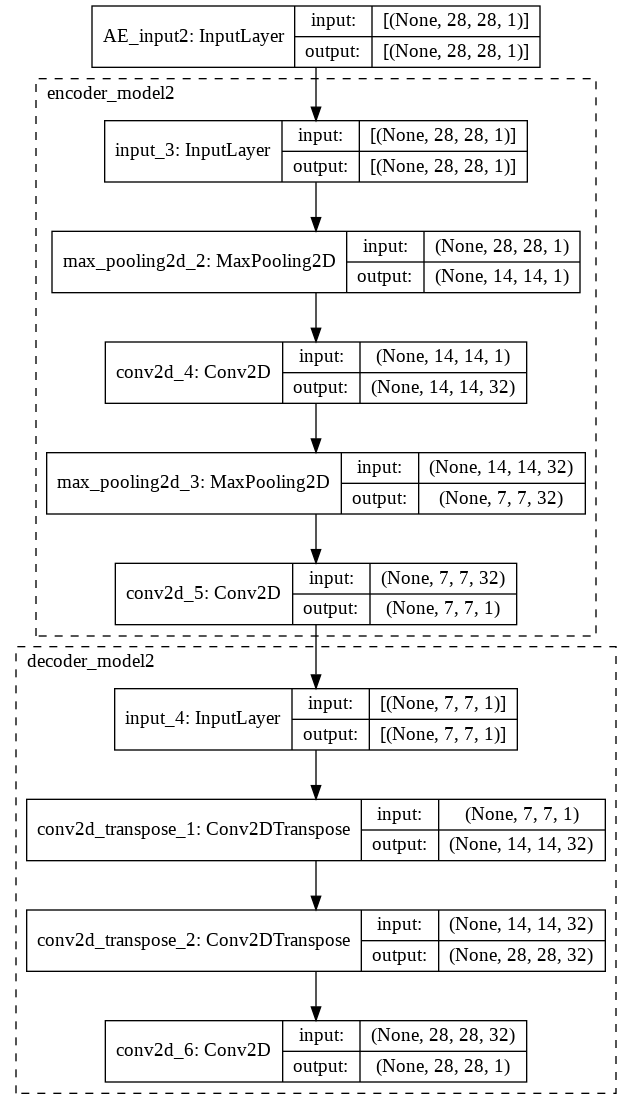

In [ ]:
#encoder
encoder_input2 = layers.Input(shape=(28, 28, 1))
x = layers.MaxPooling2D((2, 2), padding="same")(encoder_input2)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)
encoder2 = Model(encoder_input2, x, name="encoder_model2")
encoder2.summary()

# Decoder
decoder_input2 = layers.Input(shape=(7, 7, 1))
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoder_input2)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoder2 = Model(decoder_input2, x, name="decoder_model2")
decoder2.summary()

ae_input2 = layers.Input(shape=(28,28,1), name="AE_input2")
ae_encoder_output2 = encoder2(ae_input2)
ae_decoder_output2 = decoder2(ae_encoder_output2)

autoencoder2 = Model(ae_input2, ae_decoder_output2, name="AE")
autoencoder2.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder2.summary()

plot_model(autoencoder2, expand_nested=True, show_shapes=True)

In [ ]:
start = timeit.default_timer()

autoencoder2.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

end = timeit.default_timer()

print("autoencoder2 training time:", end-start)

Epoch 1/50
469/469 [==============================] - 7s 13ms/step - loss: 0.2066 - val_loss: 0.1218
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1178 - val_loss: 0.1134
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1127 - val_loss: 0.1103
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1104 - val_loss: 0.1086
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1091 - val_loss: 0.1075
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1080 - val_loss: 0.1064
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1071 - val_loss: 0.1059
Epoch 8/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1063 - val_loss: 0.1050
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1058 - val_loss: 0.1048
Epoch 10/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1052 - val_lo

# Combined 

In [ ]:
start = timeit.default_timer()

Encoded = encoder1.predict(test_data)

end = timeit.default_timer()

print("encoding time:", end-start)

encoding time: 0.4754666300000281


In [ ]:
print(np.amax(Encoded))

13.224722


Data scaling 

In [ ]:
Encoded1 = encoder1.predict(test_data)
Encoded2 = encoder2.predict(test_data)
Maximum1 = np.amax(Encoded1)
Maximum2 = np.amax(Encoded2)

#sometime inverts

def normalize(x):
  factor = (Maximum1/Maximum2)
  x = x/factor
  x = x + x*0.3
  return x


# define vectorized sigmoid
normalize_v = np.vectorize(normalize)

In [ ]:
print(Maximum2)

2.563882


In [ ]:
start = timeit.default_timer()

Encoded = normalize_v(Encoded)

end = timeit.default_timer()

print("translation time:", end-start)

translation time: 1.444932504999997


In [ ]:
start = timeit.default_timer()

Decoded = decoder2.predict(Encoded)

end = timeit.default_timer()

print("decoding time:", end-start)

decoding time: 0.5500437509999756


# finding loss

In [ ]:
Loss = []
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
'''
for i in range(10000):
  loss = bce(Decoded[i], test_data[i])
  Loss.append(loss)
'''

'\nfor i in range(10000):\n  loss = bce(Decoded[i], test_data[i])\n  Loss.append(loss)\n'

In [ ]:
# Average = sum(Loss) / len(Loss)

In [ ]:
# print(Average)

In [ ]:
Loss = []

for i in range(10000):
  loss = np.square(np.subtract(Decoded[i], test_data[i])).mean()
  Loss.append(loss)

In [ ]:
Average = sum(Loss) / len(Loss)

In [ ]:
print(Average)

0.11254192616865039


In [ ]:
Image = 950

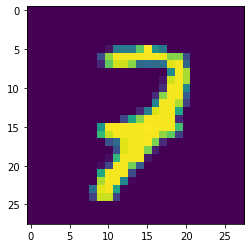

In [ ]:
plt.imshow(test_data[Image].reshape((28,28)))

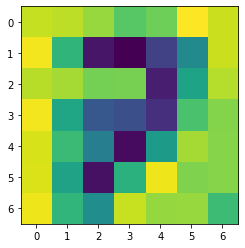

In [ ]:
plt.imshow(Encoded[Image].reshape((7,7)))

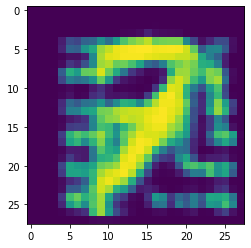

In [ ]:
plt.imshow(Decoded[Image].reshape((28,28)))